Created on Wed Nov 06 15:27 2019

This is the script for Figures 3, 4, 6 and 7 and some of the interpretation work of the ARC3O Part 1 Paper

@author: Clara Burgard

In [3]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.stats import kde
import clalib.memls_functions_2D as mf2
import clalib.profile_functions as pf
import seaborn as sns
import pandas as pd

In [ ]:
import sys
sys.path.append('../scripts_simulation/')
import analysis_functions as ana

In [4]:
sns.set_context('paper')

Mask out time points with thickness spikes when the snow melts, inferred from plot_snowiceevol.ipynb

In [5]:
timerange_notok_FYI = np.array([i for j in (range(655,687),range(1369,1407),range(2117,2146),range(2806,2879)) for i in j])
#MYI starts at 858, so substract 858 from all ranges given in snowiceevol.ipynb
timerange_notok_MYI = np.array([i for j in (range(563,582),range(1295,1319),range(2016,2045)) for i in j])

READ IN THE DATA FIRST-YEAR ICE

In [6]:
exp_nb='049'

#Experiment location
ee='75N00W-p4'
#ee='82N50E-p4'
#ee='85N50W-p4'
#ee='82N120W-p4'
#ee='80N160W-p4'
#ee='77N39E-p4'
ee2=ee.split("-")[0]

home_path='/home/mpim/m300411'

subfolder=glob.glob('/home/mpim/m300411/SatSim/git_scripts/Documentation/Experiments/README_exp'+exp_nb+'*.txt')
datet = subfolder[0].split("_")[4].split(".")[0]
inputpath2 = '/work/mh0033/m300411/SatSim/MEMLS_exp/exp'+exp_nb+'_'+ee2+'_'+datet+'/INPUT/netcdf_files/'
inputpath = '/work/mh0033/m300411/SatSim/MEMLS_exp/exp'+exp_nb+'_'+ee2+'_'+datet+'/OUTPUT/netcdf_files/'
outputpath = '/work/mh0033/m300411/SatSim//MEMLS_exp/exp'+exp_nb+'_'+ee2+'_'+datet+'/RESULTS/'

#input interpolated on equidistant layers - good to compare by depth - all sensitivity experiments
memls_input_FYI = xr.open_dataset(inputpath2+'inputMEMLS_depthidx_'+ee2+'.nc')
#input interpolated on equidistant layers - good to compare by depth - reference profiles
memls_input_comp_FYI = xr.open_dataset(inputpath2+'inputMEMLS_depthidx_complex_'+ee2+'.nc')
#input on original layers (between 0 and 100) 
memls_input_FYI_orig = xr.open_dataset(inputpath2+'inputMEMLS_'+ee2+'.nc')
#brightness temperatures assuming there is no snow layer
memls_output_FYI_snowno = xr.open_dataset(inputpath+'outputMEMLS_'+ee2+'_snowno.nc')
#brightness temperatures assuming there is a snow layer
memls_output_FYI_snowyes = xr.open_dataset(inputpath+'outputMEMLS_'+ee2+'_snowyes.nc')

timelength_FYI = memls_input_FYI['time']
ts_month_FYI = timelength_FYI['time.month']

inputpath_samsim = '/work/mh0033/m300411/SatSim/SAMSIM/'

#timeseries of snow thickness
thick_sn_file_FYI = np.loadtxt(inputpath_samsim+'75N00W-p4/dat_snow.dat') #thick_snow,T_snow,psi_l_snow,psi_s_snow
thick_sn_FYI = thick_sn_file_FYI[:,0]
thick_sn_FYI[thick_sn_FYI==0] = np.nan

#timeseries of ice thickness
thick_FYI = np.loadtxt(inputpath_samsim+"75N00W-p4/dat_thick.dat")
thick_ice_FYI = np.sum(thick_FYI,axis=1) #still contains timesteps where there is actually no ice, but no effect on our results

#add these timeseries to the input arrays
memls_input_FYI['thick_snow'] = xr.DataArray(thick_sn_FYI, coords=[timelength_FYI], dims=['time'])
memls_input_FYI['thick_ice'] = xr.DataArray(thick_ice_FYI, coords=[timelength_FYI], dims=['time'])


READ IN THE MULTIYEAR ICE DATA

In [7]:
exp_nb='050'

#Experiment location
ee='NorthPole-p4'
ee2=ee.split("-")[0]

home_path='/home/mpim/m300411'

subfolder=glob.glob('/home/mpim/m300411/SatSim/git_scripts/Documentation/Experiments/README_exp'+exp_nb+'*.txt')
datet = subfolder[0].split("_")[4].split(".")[0]
inputpath2 = '/work/mh0033/m300411/SatSim/MEMLS_exp/exp'+exp_nb+'_'+ee2+'_'+datet+'/INPUT/netcdf_files/'
inputpath = '/work/mh0033/m300411/SatSim/MEMLS_exp/exp'+exp_nb+'_'+ee2+'_'+datet+'/OUTPUT/netcdf_files/'
outputpath = '/work/mh0033/m300411/SatSim//MEMLS_exp/exp'+exp_nb+'_'+ee2+'_'+datet+'/RESULTS/'

#input interpolated on equidistant layers - good to compare by depth - all sensitivity experiments
memls_input_MYI = xr.open_dataset(inputpath2+'inputMEMLS_depthidx_'+ee2+'.nc')
#input on original layers (between 0 and 100) 
memls_input_MYI_orig = xr.open_dataset(inputpath2+'inputMEMLS_'+ee2+'.nc')
#brightness temperatures assuming there is no snow layer
memls_output_MYI_snowno = xr.open_dataset(inputpath+'outputMEMLS_'+ee2+'_snowno.nc')
#brightness temperatures assuming there is a snow layer
memls_output_MYI_snowyes = xr.open_dataset(inputpath+'outputMEMLS_'+ee2+'_snowyes.nc')

#timeseries of snow thickness
thick_sn_file_MYI = np.loadtxt(inputpath_samsim+'NorthPole-p4/dat_snow.dat') #thick_snow,T_snow,psi_l_snow,psi_s_snow
thick_sn_MYI = thick_sn_file_MYI[:,0]
thick_sn_MYI[thick_sn_MYI==0] = np.nan

#timeseries of ice thickness
thick_MYI = np.loadtxt(inputpath_samsim+"NorthPole-p4/dat_thick.dat")
thick_ice_MYI = np.sum(thick_MYI,axis=1) #still contains timesteps where there is actually no ice, but no effect on our results

#add these timeseries to the input arrays
memls_input_MYI['thick_snow'] = xr.DataArray(thick_sn_MYI, coords=[timelength_FYI], dims=['time'])
memls_input_MYI['thick_ice'] = xr.DataArray(thick_ice_MYI, coords=[timelength_FYI], dims=['time'])

timelength = memls_input_MYI['time']

#this experiment contains one year of first-year ice, then multiyear ice, so we filter out the FYI
timelength_MYI = timelength[memls_input_MYI['type'].sel(sens_exp='complex').median('depth')==4.].drop('sens_exp')
memls_output_MYI_snowno = memls_output_MYI_snowno.sel(time=timelength_MYI)
memls_output_MYI_snowyes = memls_output_MYI_snowyes.sel(time=timelength_MYI)
memls_input_MYI = memls_input_MYI.sel(time=timelength_MYI)
memls_input_MYI_orig = memls_input_MYI_orig.sel(time=timelength_MYI)
ts_month_MYI = timelength_MYI['time.month']


/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


COMPUTE THE ICE SUBSURFACE BRINE VOLUME WATER FRACTION

In [8]:
surf_lwf_ice0 = xr.DataArray(np.zeros((len(memls_input_FYI['time']),len(memls_input_FYI['sens_exp']))), coords=[
                                ('time',memls_input_FYI.time.values),
                                ('sens_exp',memls_input_FYI.sens_exp.values)])
surf_lwf_ice_FYI = surf_lwf_ice0*np.nan
surf_lwf_ice_MYI = surf_lwf_ice0*np.nan

#write out the brine volume fraction at the surface
for sens_exp in memls_input_FYI.sens_exp:
    print(sens_exp.values)
    #FYI
    for tt,timet in enumerate(memls_input_FYI['time']):
        #take part of the array without snow to get the top ice layer
        temporary = memls_input_FYI_orig['liquid_water_fraction'].sel(time=timet,sens_exp=sens_exp).where(memls_input_FYI_orig['snow_ice'].sel(time=timet,sens_exp=sens_exp)>0).dropna('top_100_to_bottom_0')
        if len(temporary)>0:
            surf_lwf_ice_FYI.loc[dict(time=timet,sens_exp=sens_exp)] = temporary.values[0]
        #MYI
        if timet.values in memls_input_MYI['time']:
            #take part of the array without snow to get the top ice layer
            temporary2 = memls_input_MYI_orig['liquid_water_fraction'].sel(time=timet,sens_exp=sens_exp).where(memls_input_MYI_orig['snow_ice'].sel(time=timet,sens_exp=sens_exp)>0).dropna('top_100_to_bottom_0')
            if len(temporary2)>0:
                surf_lwf_ice_MYI.loc[dict(time=timet,sens_exp=sens_exp)] = temporary2.values[0]


complex
simpletemp
simplesalfunc
simpleallfunc
simplesalconst
simpleallconst


PREPARE FIGURE SPECIFICS

In [9]:
outputpath_fig = '/work/mh0033/m300411/SatSim/Paper_plots/'

moncol = ['mediumpurple','darkorchid','palevioletred','sandybrown','gold','darkorange','maroon','red','olive','deepskyblue','navy','blue']

#params = {'legend.fontsize': 'xx-large',
#          'figure.figsize': (7,7),
#         'axes.labelsize': 'xx-large',
#         'axes.titlesize':'xx-large',
#         'xtick.labelsize':'xx-large',
#         'ytick.labelsize':'xx-large'}
#mpl.rcParams.update(params)

alph = 0.2

siz = 10

xx = range(60,300) 

SUBSURFACE BRINE VOLUME FRACTION AGAINST TBV - PREPARATION FIGURE 3

In [10]:
TBV_comp_FYI_yes = memls_output_FYI_snowyes['tb_v'].sel(sens_exp='complex',frequency=6.9)
#TBV_simp_FYI_yes = memls_output_FYI_snowyes['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
TBV_comp_FYI_no = memls_output_FYI_snowno['tb_v'].sel(sens_exp='complex',frequency=6.9)
#TBV_simp_FYI_no = memls_output_FYI_snowno['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
TBV_comp_FYI_yes[timerange_notok_FYI] = np.nan
TBV_comp_FYI_no[timerange_notok_FYI] = np.nan

surf_lwf_FYI = surf_lwf_ice_FYI
surf_lwf_FYI[timerange_notok_FYI] = np.nan


y_actual_FYI = surf_lwf_FYI.sel(sens_exp='complex')
y_predicted_FYI_no = TBV_comp_FYI_no
y_predicted_FYI_yes = TBV_comp_FYI_yes

corrcoeff_FYI_yes = np.corrcoef(y_actual_FYI[~np.isnan(y_actual_FYI) & ~np.isnan(y_predicted_FYI_yes)],y_predicted_FYI_yes[~np.isnan(y_actual_FYI) & ~np.isnan(y_predicted_FYI_yes)])[0,1]
corrcoeff_FYI_no = np.corrcoef(y_actual_FYI[~np.isnan(y_actual_FYI) & ~np.isnan(y_predicted_FYI_no)],y_predicted_FYI_no[~np.isnan(y_actual_FYI) & ~np.isnan(y_predicted_FYI_no)])[0,1]

TBV_comp_MYI_yes = memls_output_MYI_snowyes['tb_v'].sel(sens_exp='complex',frequency=6.9).sel(time=memls_input_MYI['time'])
TBV_comp_MYI_no = memls_output_MYI_snowno['tb_v'].sel(sens_exp='complex',frequency=6.9).sel(time=memls_input_MYI['time'])
TBV_comp_MYI_yes[timerange_notok_MYI] = np.nan
TBV_comp_MYI_no[timerange_notok_MYI] = np.nan

surf_lwf_MYI = surf_lwf_ice_MYI.sel(time=timelength_MYI)
surf_lwf_MYI[timerange_notok_MYI] = np.nan

y_actual_MYI = surf_lwf_MYI.sel(sens_exp='complex')
y_predicted_MYI_no = TBV_comp_MYI_no
y_predicted_MYI_yes = TBV_comp_MYI_yes

corrcoeff_MYI_yes = np.corrcoef(y_actual_MYI[~np.isnan(y_actual_MYI) & ~np.isnan(y_predicted_MYI_yes)],y_predicted_MYI_yes[~np.isnan(y_actual_MYI) & ~np.isnan(y_predicted_MYI_yes)])[0,1]
corrcoeff_MYI_no = np.corrcoef(y_actual_MYI[~np.isnan(y_actual_MYI) & ~np.isnan(y_predicted_MYI_no)],y_predicted_MYI_no[~np.isnan(y_actual_MYI) & ~np.isnan(y_predicted_MYI_no)])[0,1]


FIGURE 3

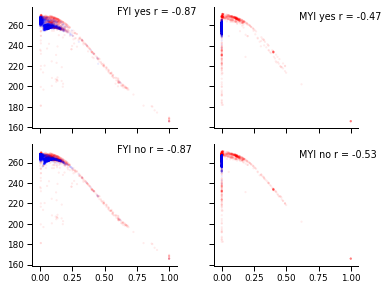

In [11]:
siz = 5
alph=0.075
#mpl.rcParams.update({'font.size': 14})
#mpl.rcParams.update({'axes.labelsize': 16})

f, axs = plt.subplots(2, 2, sharex=True, sharey=True)
f.set_size_inches(8.27/1.5,8.27/2)
#f.subplots_adjust(bottom=0.07)
#f.subplots_adjust(left=0.07)
#f.subplots_adjust(right=0.95)
#f.subplots_adjust(top=0.92)
#f.subplots_adjust(hspace=0.07, wspace=0.05)


axs[0, 0].scatter(surf_lwf_FYI.sel(sens_exp='complex',time=ana.is_summer(ts_month_FYI)),TBV_comp_FYI_yes.sel(time=ana.is_summer(ts_month_FYI)),c='r',alpha=alph,s=siz,edgecolors='None')
axs[0, 0].scatter(surf_lwf_FYI.sel(sens_exp='complex',time=ana.is_winter(ts_month_FYI)),TBV_comp_FYI_yes.sel(time=ana.is_winter(ts_month_FYI)),c='b',alpha=alph,s=siz,edgecolors='None')
axs[1, 0].scatter(surf_lwf_FYI.sel(sens_exp='complex',time=ana.is_summer(ts_month_FYI)),TBV_comp_FYI_no.sel(time=ana.is_summer(ts_month_FYI)),c='r',alpha=alph,s=siz,edgecolors='None')
axs[1, 0].scatter(surf_lwf_FYI.sel(sens_exp='complex',time=ana.is_winter(ts_month_FYI)),TBV_comp_FYI_no.sel(time=ana.is_winter(ts_month_FYI)),c='b',alpha=alph,s=siz,edgecolors='None')

axs[0, 1].scatter(surf_lwf_MYI.sel(sens_exp='complex',time=ana.is_summer(ts_month_MYI)),TBV_comp_MYI_yes.sel(time=ana.is_summer(ts_month_MYI)),c='r',alpha=alph,s=siz,edgecolors='None')
axs[0, 1].scatter(surf_lwf_MYI.sel(sens_exp='complex',time=ana.is_winter(ts_month_MYI)),TBV_comp_MYI_yes.sel(time=ana.is_winter(ts_month_MYI)),c='b',alpha=alph,s=siz,edgecolors='None')
axs[1, 1].scatter(surf_lwf_MYI.sel(sens_exp='complex',time=ana.is_summer(ts_month_MYI)),TBV_comp_MYI_no.sel(time=ana.is_summer(ts_month_MYI)),c='r',alpha=alph,s=siz,edgecolors='None')
axs[1, 1].scatter(surf_lwf_MYI.sel(sens_exp='complex',time=ana.is_winter(ts_month_MYI)),TBV_comp_MYI_no.sel(time=ana.is_winter(ts_month_MYI)),c='b',alpha=alph,s=siz,edgecolors='None')


#plt.xlabel('Ice subsurface brine volume fraction')
#plt.ylabel('Brightness temperature V-pol 6.9 GHz [K]')
axs[0, 0].text(0.6,270,'FYI yes r = '+str(np.round(corrcoeff_FYI_yes,2)))
axs[0, 1].text(0.6,265,'MYI yes r = '+str(np.round(corrcoeff_MYI_yes,2)))
axs[1, 0].text(0.6,270,'FYI no r = '+str(np.round(corrcoeff_FYI_no,2)))
axs[1, 1].text(0.6,265,'MYI no r = '+str(np.round(corrcoeff_MYI_no,2)))
#sns.despine(offset=10)
sns.despine()
plt.tight_layout()
#f.savefig(outputpath_fig+'Figure3.pdf',rasterize=True,bbox_inches='tight')

SENSITIVITY STUDIES - SIMPLETEMP - FIGURE 4

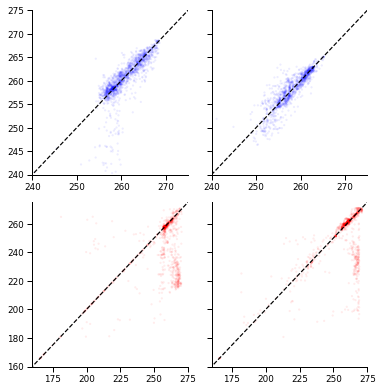

In [13]:
siz = 5
alph=0.075

corrcoeff = np.zeros((5,2))
mean_diff = np.zeros((5,2))
std_diff = np.zeros((5,2))

memls_output_FYI = memls_output_FYI_snowyes.copy()
memls_output_MYI = memls_output_MYI_snowyes.copy()


# mpl.rcParams.update({'font.size': 30})
# mpl.rcParams.update({'axes.labelsize': 14})

f, axs = plt.subplots(2, 2)

#define format     
f.set_size_inches(8.72/1.5,8.72/1.5)
#f.subplots_adjust(bottom=0.4)
#f.subplots_adjust(left=0.4)
# f.subplots_adjust(right=0.95)
# f.subplots_adjust(top=0.92)
# f.subplots_adjust(hspace=0.07, wspace=0.05)

y1 = memls_output_FYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y4 = memls_output_FYI['tb_v'].sel(sens_exp='simpletemp',frequency=6.9)

y1[timerange_notok_FYI] = np.nan
y4[timerange_notok_FYI] = np.nan

y1b = memls_output_MYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y4b = memls_output_MYI['tb_v'].sel(sens_exp='simpletemp',frequency=6.9)

y1b[timerange_notok_MYI] = np.nan
y4b[timerange_notok_MYI] = np.nan

upper_lim = 275
axs[0,0].set_xlim(240,upper_lim)
axs[0,0].set_ylim(240,upper_lim)
axs[0,1].set_xlim(240,upper_lim)
axs[0,1].set_ylim(240,upper_lim)
axs[1,0].set_xlim(160,upper_lim)
axs[1,0].set_ylim(160,upper_lim)
axs[1,1].set_xlim(160,upper_lim)
axs[1,1].set_ylim(160,upper_lim)

axs[0, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y4.sel(time=ana.is_winter(ts_month_FYI)), c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y4b.sel(time=ana.is_winter(ts_month_MYI)), c='b', edgecolors='None',alpha=alph, s=siz)

axs[1, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y4.sel(time=ana.is_summer(ts_month_FYI)), c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y4b.sel(time=ana.is_summer(ts_month_MYI)), c='r', edgecolors='None',alpha=alph, s=siz)

     
for i in range(2):
    for j in range(2):
        axs[i,j].plot(xx,xx,'k--')
        axs[i,j].tick_params(axis='both', which='major')#, labelsize=30)
   
     
#plt.setp([a.get_xticklabels() for a in axs[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axs[:, 1]], visible=False)
#plt.setp([a.get_xticklabels() for a in axs[:, 0]])
#plt.setp([a.get_xticklabels() for a in axs[:, 1]])

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.xlabel(' Reference brightness temperatures [K]')
#plt.ylabel('Brightness temperatures simulated from simplified profiles [K]')

#f.text(0.5,0.01,' "Real" brightness temperatures [K]' ,ha='center')
#f.text(0.03,0.7, 'Brightness temperatures simulated from simplified profiles [K]' ,ha='center',rotation='vertical')
#f.savefig(outputpath+'sensitivitystudies_V_FYI.pdf',bbox_inches='tight',orientation='landscape')
sns.despine()
plt.tight_layout()

#f.savefig(outputpath_fig+'Figure4.pdf',rasterize=True,bbox_inches='tight')

SENSITIVITY STUDIES - SIMPLESAL - FIGURE 6

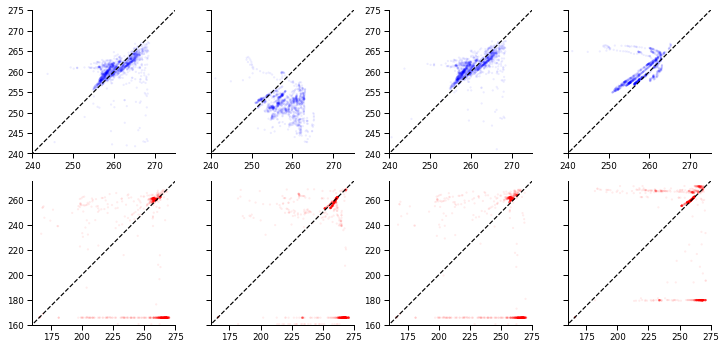

In [15]:
siz = 5
alph=0.075

corrcoeff = np.zeros((5,2))
mean_diff = np.zeros((5,2))
std_diff = np.zeros((5,2))

memls_output_FYI = memls_output_FYI_snowyes.copy()
memls_output_MYI = memls_output_MYI_snowyes.copy()


# mpl.rcParams.update({'font.size': 30})
# mpl.rcParams.update({'axes.labelsize': 14})

f, axs = plt.subplots(2, 4)

#define format     
f.set_size_inches(8.72*1.2,8.72*0.6)
#f.subplots_adjust(bottom=0.4)
#f.subplots_adjust(left=0.4)
# f.subplots_adjust(right=0.95)
# f.subplots_adjust(top=0.92)
# f.subplots_adjust(hspace=0.07, wspace=0.05)

y1 = memls_output_FYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y5 = memls_output_FYI['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9)
y6 = memls_output_FYI['tb_v'].sel(sens_exp='simplesalconst',frequency=6.9)

y1[timerange_notok_FYI] = np.nan
y5[timerange_notok_FYI] = np.nan
y6[timerange_notok_FYI] = np.nan

y1b = memls_output_MYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y5b = memls_output_MYI['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9)
y6b = memls_output_MYI['tb_v'].sel(sens_exp='simplesalconst',frequency=6.9)

y1b[timerange_notok_MYI] = np.nan
y5b[timerange_notok_MYI] = np.nan
y6b[timerange_notok_MYI] = np.nan

upper_lim=275
axs[0,0].set_xlim(240,upper_lim)
axs[0,0].set_ylim(240,upper_lim)
axs[0,1].set_xlim(240,upper_lim)
axs[0,1].set_ylim(240,upper_lim)
axs[0,2].set_xlim(240,upper_lim)
axs[0,2].set_ylim(240,upper_lim)
axs[0,3].set_xlim(240,upper_lim)
axs[0,3].set_ylim(240,upper_lim)
axs[1,0].set_xlim(160,upper_lim)
axs[1,0].set_ylim(160,upper_lim)
axs[1,1].set_xlim(160,upper_lim)
axs[1,1].set_ylim(160,upper_lim)
axs[1,2].set_xlim(160,upper_lim)
axs[1,2].set_ylim(160,upper_lim)
axs[1,3].set_xlim(160,upper_lim)
axs[1,3].set_ylim(160,upper_lim)

axs[0, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y6.sel(time=ana.is_winter(ts_month_FYI)), c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y6b.sel(time=ana.is_winter(ts_month_MYI)), c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 2].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y5.sel(time=ana.is_winter(ts_month_FYI)), c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 3].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y5b.sel(time=ana.is_winter(ts_month_MYI)), c='b', edgecolors='None',alpha=alph, s=siz)


axs[1, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y6.sel(time=ana.is_summer(ts_month_FYI)), c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y6b.sel(time=ana.is_summer(ts_month_MYI)), c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 2].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y5.sel(time=ana.is_summer(ts_month_FYI)), c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 3].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y5b.sel(time=ana.is_summer(ts_month_MYI)), c='r', edgecolors='None',alpha=alph, s=siz)


     
for i in range(2):
    for j in range(4):
        axs[i,j].plot(xx,xx,'k--')
        axs[i,j].tick_params(axis='both', which='major')#, labelsize=30)
   
     
#plt.setp([a.get_xticklabels() for a in axs[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axs[:, 1]], visible=False)
#plt.setp([a.get_yticklabels() for a in axs[:, 2]], visible=False)
plt.setp([a.get_yticklabels() for a in axs[:, 3]], visible=False)
#plt.setp([a.get_xticklabels() for a in axs[:, 0]])
#plt.setp([a.get_xticklabels() for a in axs[:, 1]])

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.xlabel(' Reference brightness temperatures [K]')
#plt.ylabel('Brightness temperatures simulated from simplified profiles [K]')

#f.text(0.5,0.01,' Reference brightness temperatures [K]' ,ha='center')
#f.text(0.03,0.7, 'Brightness temperatures simulated from simplified profiles [K]' ,ha='center',rotation='vertical')
sns.despine()
plt.tight_layout()

#f.savefig(outputpath_fig+'Figure6.pdf',rasterize=True,bbox_inches='tight')

SENSITIVITY STUDIES - SIMPLEALL - FIGURE 7

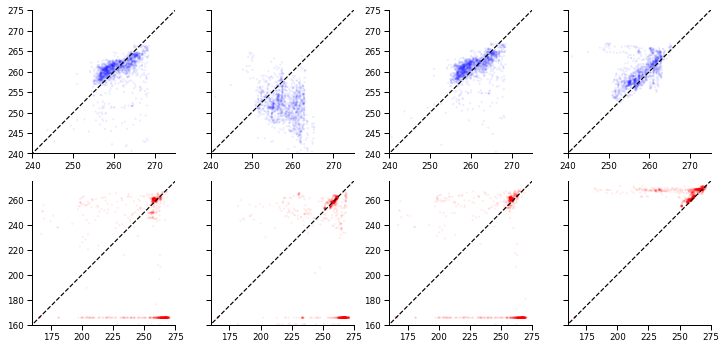

In [16]:


siz = 5
alph=0.075

corrcoeff = np.zeros((5,2))
mean_diff = np.zeros((5,2))
std_diff = np.zeros((5,2))

memls_output_FYI = memls_output_FYI_snowyes.copy()
memls_output_MYI = memls_output_MYI_snowyes.copy()


# mpl.rcParams.update({'font.size': 30})
# mpl.rcParams.update({'axes.labelsize': 14})

f, axs = plt.subplots(2, 4)

#define format     
f.set_size_inches(8.72*1.2,8.72*0.6)
#f.subplots_adjust(bottom=0.4)
#f.subplots_adjust(left=0.4)
# f.subplots_adjust(right=0.95)
# f.subplots_adjust(top=0.92)
# f.subplots_adjust(hspace=0.07, wspace=0.05)

y1 = memls_output_FYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y2 = memls_output_FYI['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
y3 = memls_output_FYI['tb_v'].sel(sens_exp='simpleallconst',frequency=6.9)

y1[timerange_notok_FYI] = np.nan
y2[timerange_notok_FYI] = np.nan
y3[timerange_notok_FYI] = np.nan

y1b = memls_output_MYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y2b = memls_output_MYI['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
y3b = memls_output_MYI['tb_v'].sel(sens_exp='simpleallconst',frequency=6.9)

y1b[timerange_notok_MYI] = np.nan
y2b[timerange_notok_MYI] = np.nan
y3b[timerange_notok_MYI] = np.nan


upper_lim=275
axs[0,0].set_xlim(240,upper_lim)
axs[0,0].set_ylim(240,upper_lim)
axs[0,1].set_xlim(240,upper_lim)
axs[0,1].set_ylim(240,upper_lim)
axs[0,2].set_xlim(240,upper_lim)
axs[0,2].set_ylim(240,upper_lim)
axs[0,3].set_xlim(240,upper_lim)
axs[0,3].set_ylim(240,upper_lim)
axs[1,0].set_xlim(160,upper_lim)
axs[1,0].set_ylim(160,upper_lim)
axs[1,1].set_xlim(160,upper_lim)
axs[1,1].set_ylim(160,upper_lim)
axs[1,2].set_xlim(160,upper_lim)
axs[1,2].set_ylim(160,upper_lim)
axs[1,3].set_xlim(160,upper_lim)
axs[1,3].set_ylim(160,upper_lim)

axs[0, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y3.sel(time=ana.is_winter(ts_month_FYI)), c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y3b.sel(time=ana.is_winter(ts_month_MYI)), c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 2].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y2.sel(time=ana.is_winter(ts_month_FYI)), c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 3].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y2b.sel(time=ana.is_winter(ts_month_MYI)), c='b', edgecolors='None',alpha=alph, s=siz)


axs[1, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y3.sel(time=ana.is_summer(ts_month_FYI)), c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y3b.sel(time=ana.is_summer(ts_month_MYI)), c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 2].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y2.sel(time=ana.is_summer(ts_month_FYI)), c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 3].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y2b.sel(time=ana.is_summer(ts_month_MYI)), c='r', edgecolors='None',alpha=alph, s=siz)


     
for i in range(2):
    for j in range(4):
        axs[i,j].plot(xx,xx,'k--')
        axs[i,j].tick_params(axis='both', which='major')#, labelsize=30)
   
     
#plt.setp([a.get_xticklabels() for a in axs[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axs[:, 1]], visible=False)
#plt.setp([a.get_yticklabels() for a in axs[:, 2]], visible=False)
plt.setp([a.get_yticklabels() for a in axs[:, 3]], visible=False)
#plt.setp([a.get_xticklabels() for a in axs[:, 0]])
#plt.setp([a.get_xticklabels() for a in axs[:, 1]])

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.xlabel(' Reference brightness temperatures [K]')
#plt.ylabel('Brightness temperatures simulated from simplified profiles [K]')

#f.text(0.5,0.01,' "Real" brightness temperatures [K]' ,ha='center')
#f.text(0.03,0.7, 'Brightness temperatures simulated from simplified profiles [K]' ,ha='center',rotation='vertical')
sns.despine()
plt.tight_layout()

#f.savefig(outputpath_fig+'Figure7.pdf',rasterize=True,bbox_inches='tight')

SUMMARY FIGURE SUMMER WITH THE MEAN DIFF NUMBERS FOR FIGURES 4, 6, 7

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  color or c: color
  contains: callable
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font_properties: `.font_manager.FontProperties`
  fontsize or size: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or w

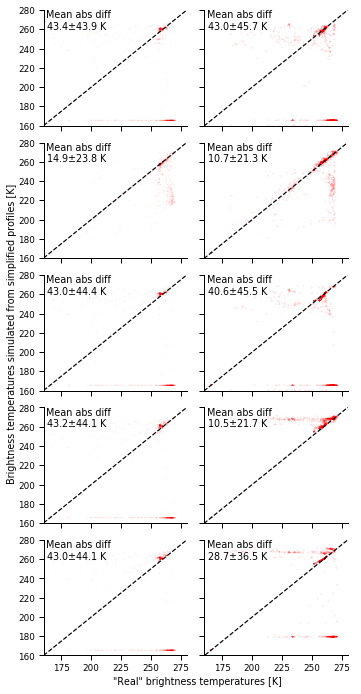

In [17]:

siz = 5

corrcoeff = np.zeros((5,2))
mean_diff = np.zeros((5,2))
std_diff = np.zeros((5,2))

memls_output_FYI = memls_output_FYI_snowyes.copy()
memls_output_MYI = memls_output_MYI_snowyes.copy()

for i,sity in enumerate(['FYI','MYI']):
    if sity == 'FYI':
        y_actual = memls_output_FYI['tb_v'].sel(sens_exp='complex',frequency=6.9,time=ana.is_summer(ts_month_FYI))
    elif sity == 'MYI':
         y_actual = memls_output_MYI['tb_v'].sel(sens_exp='complex',frequency=6.9,time=ana.is_summer(ts_month_MYI))
        
    for j,exp in enumerate(['simpleallconst','simpletemp','simplesalconst','simpleallfunc','simplesalfunc']):
        if sity == 'FYI':
            y_predicted = memls_output_FYI['tb_v'].sel(sens_exp=exp,frequency=6.9,time=ana.is_summer(ts_month_FYI))
        elif sity == 'MYI':
             y_predicted = memls_output_MYI['tb_v'].sel(sens_exp=exp,frequency=6.9,time=ana.is_summer(ts_month_MYI))

        ydiff = abs(y_predicted - y_actual)
#        mean_diff[i,j] = np.mean(abs(ydiff))
#        std_diff[i,j] = np.std(abs(ydiff))
        mean_diff[j,i] = np.mean(ydiff)
        std_diff[j,i] = np.std(ydiff)
        corrcoeff[j,i] = np.corrcoef(y_actual[~np.isnan(y_actual) & ~np.isnan(y_predicted)],y_predicted[~np.isnan(y_actual) & ~np.isnan(y_predicted)])[0,1]

# mpl.rcParams.update({'font.size': 30})
# mpl.rcParams.update({'axes.labelsize': 14})

f, axs = plt.subplots(5, 2, sharex=True, sharey=True)

#define format     
f.set_size_inches(5.5,10)
#f.subplots_adjust(bottom=0.4)
#f.subplots_adjust(left=0.4)
# f.subplots_adjust(right=0.95)
# f.subplots_adjust(top=0.92)
# f.subplots_adjust(hspace=0.07, wspace=0.05)

y1 = memls_output_FYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y2 = memls_output_FYI['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
y3 = memls_output_FYI['tb_v'].sel(sens_exp='simpleallconst',frequency=6.9)
y4 = memls_output_FYI['tb_v'].sel(sens_exp='simpletemp',frequency=6.9)
y5 = memls_output_FYI['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9)
y6 = memls_output_FYI['tb_v'].sel(sens_exp='simplesalconst',frequency=6.9)

y1[timerange_notok_FYI] = np.nan
y2[timerange_notok_FYI] = np.nan
y3[timerange_notok_FYI] = np.nan
y4[timerange_notok_FYI] = np.nan
y5[timerange_notok_FYI] = np.nan
y6[timerange_notok_FYI] = np.nan

y1b = memls_output_MYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y2b = memls_output_MYI['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
y3b = memls_output_MYI['tb_v'].sel(sens_exp='simpleallconst',frequency=6.9)
y4b = memls_output_MYI['tb_v'].sel(sens_exp='simpletemp',frequency=6.9)
y5b = memls_output_MYI['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9)
y6b = memls_output_MYI['tb_v'].sel(sens_exp='simplesalconst',frequency=6.9)

y1b[timerange_notok_MYI] = np.nan
y2b[timerange_notok_MYI] = np.nan
y3b[timerange_notok_MYI] = np.nan
y4b[timerange_notok_MYI] = np.nan
y5b[timerange_notok_MYI] = np.nan
y6b[timerange_notok_MYI] = np.nan

axs[0,0].set_xlim(160,280)
axs[0,0].set_ylim(160,280)

axs[3, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y2.sel(time=ana.is_summer(ts_month_FYI)), marker='.', c='r', edgecolors='None', alpha=alph, s=siz)
axs[0, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y3.sel(time=ana.is_summer(ts_month_FYI)), marker='.', c='r', edgecolors='None', alpha=alph, s=siz)
axs[1, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y4.sel(time=ana.is_summer(ts_month_FYI)), marker='.', c='r', edgecolors='None',alpha=alph, s=siz)
axs[4, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y5.sel(time=ana.is_summer(ts_month_FYI)), marker='.', c='r', edgecolors='None',alpha=alph, s=siz)
axs[2, 0].scatter(y1.sel(time=ana.is_summer(ts_month_FYI)),y6.sel(time=ana.is_summer(ts_month_FYI)), marker='.', c='r', edgecolors='None',alpha=alph, s=siz)
  
axs[3, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y2b.sel(time=ana.is_summer(ts_month_MYI)), marker='P', c='r', edgecolors='None',alpha=alph, s=siz)
axs[0, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y3b.sel(time=ana.is_summer(ts_month_MYI)), marker='P', c='r', edgecolors='None',alpha=alph, s=siz)
axs[1, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y4b.sel(time=ana.is_summer(ts_month_MYI)), marker='P', c='r', edgecolors='None',alpha=alph, s=siz)
axs[4, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y5b.sel(time=ana.is_summer(ts_month_MYI)), marker='P', c='r', edgecolors='None',alpha=alph, s=siz)
axs[2, 1].scatter(y1b.sel(time=ana.is_summer(ts_month_MYI)),y6b.sel(time=ana.is_summer(ts_month_MYI)), marker='P', c='r', edgecolors='None',alpha=alph, s=siz)

     
for i in range(5):
    for j in range(2):
        axs[i,j].plot(xx,xx,'k--')
        #axs[i, j].text(162,272,'r = '+str(np.round(corrcoeff[i,j],2)))
        axs[i, j].text(162,272,'Mean abs diff')
        axs[i, j].text(162,260,str(round(mean_diff[i,j],1))+'$\pm$'+str(round(std_diff[i,j],1))+' K')
        #axs[i, j].text(162,265,'Mean abs $\Delta$ = '+str(round(mean_diff[i,j],2))+'$\pm$'+str(round(std_diff[i,j],2))+' K')
        #axs[i,j].tick_params(axis='both', which='major')#, labelsize=30)
   
     
plt.setp([a.get_xticklabels() for a in axs[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axs[:, 1]], visible=False)
plt.setp([a.get_xticklabels() for a in axs[:, 0]])
plt.setp([a.get_xticklabels() for a in axs[:, 1]])

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(' Reference brightness temperatures [K]')
plt.ylabel('Brightness temperatures simulated from simplified profiles [K]')

#f.text(0.5,0.01,' "Real" brightness temperatures [K]' ,ha='center')
#f.text(0.03,0.7, 'Brightness temperatures simulated from simplified profiles [K]' ,ha='center',rotation='vertical')
#f.savefig(outputpath+'sensitivitystudies_V_FYI.pdf',bbox_inches='tight',orientation='landscape')
sns.despine()
plt.tight_layout()

#f.savefig(outputpath_fig+'sensitivity_TBV_summer_withsnow'+ee2+'_May2020.pdf',rasterize=True,bbox_inches='tight')

SUMMARY FIGURE WINTER WITH THE MEAN DIFF NUMBERS FOR FIGURES 4, 6, 7

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  color or c: color
  contains: callable
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font_properties: `.font_manager.FontProperties`
  fontsize or size: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or w

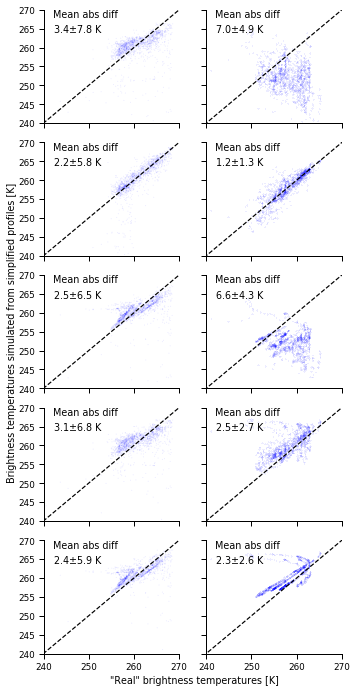

In [18]:

siz = 5

corrcoeff = np.zeros((5,2))
mean_diff = np.zeros((5,2))
std_diff = np.zeros((5,2))

memls_output_FYI = memls_output_FYI_snowyes.copy()
memls_output_MYI = memls_output_MYI_snowyes.copy()


for i,sity in enumerate(['FYI','MYI']):
    if sity == 'FYI':
        y_actual = memls_output_FYI['tb_v'].sel(sens_exp='complex',frequency=6.9,time=ana.is_winter(ts_month_FYI))
    elif sity == 'MYI':
        y_actual = memls_output_MYI['tb_v'].sel(sens_exp='complex',frequency=6.9,time=ana.is_winter(ts_month_MYI))
        
    for j,exp in enumerate(['simpleallconst','simpletemp','simplesalconst','simpleallfunc','simplesalfunc']):
        if sity == 'FYI':
            y_predicted = memls_output_FYI['tb_v'].sel(sens_exp=exp,frequency=6.9,time=ana.is_winter(ts_month_FYI))
        elif sity == 'MYI':
            y_predicted = memls_output_MYI['tb_v'].sel(sens_exp=exp,frequency=6.9,time=ana.is_winter(ts_month_MYI))

        ydiff = abs(y_predicted - y_actual)
#        mean_diff[i,j] = np.mean(abs(ydiff))
#        std_diff[i,j] = np.std(abs(ydiff))
        mean_diff[j,i] = np.mean(ydiff)
        std_diff[j,i] = np.std(ydiff)
        corrcoeff[j,i] = np.corrcoef(y_actual[~np.isnan(y_actual) & ~np.isnan(y_predicted)],y_predicted[~np.isnan(y_actual) & ~np.isnan(y_predicted)])[0,1]

# mpl.rcParams.update({'font.size': 30})
# mpl.rcParams.update({'axes.labelsize': 14})

f, axs = plt.subplots(5, 2, sharex=True, sharey=True)

#define format     
f.set_size_inches(5.5,10)
#f.subplots_adjust(bottom=0.4)
#f.subplots_adjust(left=0.4)
# f.subplots_adjust(right=0.95)
# f.subplots_adjust(top=0.92)
# f.subplots_adjust(hspace=0.07, wspace=0.05)

y1 = memls_output_FYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y2 = memls_output_FYI['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
y3 = memls_output_FYI['tb_v'].sel(sens_exp='simpleallconst',frequency=6.9)
y4 = memls_output_FYI['tb_v'].sel(sens_exp='simpletemp',frequency=6.9)
y5 = memls_output_FYI['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9)
y6 = memls_output_FYI['tb_v'].sel(sens_exp='simplesalconst',frequency=6.9)

y1[timerange_notok_FYI] = np.nan
y2[timerange_notok_FYI] = np.nan
y3[timerange_notok_FYI] = np.nan
y4[timerange_notok_FYI] = np.nan
y5[timerange_notok_FYI] = np.nan
y6[timerange_notok_FYI] = np.nan

y1b = memls_output_MYI['tb_v'].sel(sens_exp='complex',frequency=6.9)
y2b = memls_output_MYI['tb_v'].sel(sens_exp='simpleallfunc',frequency=6.9)
y3b = memls_output_MYI['tb_v'].sel(sens_exp='simpleallconst',frequency=6.9)
y4b = memls_output_MYI['tb_v'].sel(sens_exp='simpletemp',frequency=6.9)
y5b = memls_output_MYI['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9)
y6b = memls_output_MYI['tb_v'].sel(sens_exp='simplesalconst',frequency=6.9)

y1b[timerange_notok_MYI] = np.nan
y2b[timerange_notok_MYI] = np.nan
y3b[timerange_notok_MYI] = np.nan
y4b[timerange_notok_MYI] = np.nan
y5b[timerange_notok_MYI] = np.nan
y6b[timerange_notok_MYI] = np.nan



axs[0,0].set_xlim(240,270)
axs[0,0].set_ylim(240,270)

axs[3, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y2.sel(time=ana.is_winter(ts_month_FYI)), marker='.', c='b', edgecolors='None', alpha=alph, s=siz)
axs[0, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y3.sel(time=ana.is_winter(ts_month_FYI)), marker='.', c='b', edgecolors='None', alpha=alph, s=siz)
axs[1, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y4.sel(time=ana.is_winter(ts_month_FYI)), marker='.', c='b', edgecolors='None',alpha=alph, s=siz)
axs[4, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y5.sel(time=ana.is_winter(ts_month_FYI)), marker='.', c='b', edgecolors='None',alpha=alph, s=siz)
axs[2, 0].scatter(y1.sel(time=ana.is_winter(ts_month_FYI)),y6.sel(time=ana.is_winter(ts_month_FYI)), marker='.', c='b', edgecolors='None',alpha=alph, s=siz)
  
axs[3, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y2b.sel(time=ana.is_winter(ts_month_MYI)), marker='P', c='b', edgecolors='None',alpha=alph, s=siz)
axs[0, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y3b.sel(time=ana.is_winter(ts_month_MYI)), marker='P', c='b', edgecolors='None',alpha=alph, s=siz)
axs[1, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y4b.sel(time=ana.is_winter(ts_month_MYI)), marker='P', c='b', edgecolors='None',alpha=alph, s=siz)
axs[4, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y5b.sel(time=ana.is_winter(ts_month_MYI)), marker='P', c='b', edgecolors='None',alpha=alph, s=siz)
axs[2, 1].scatter(y1b.sel(time=ana.is_winter(ts_month_MYI)),y6b.sel(time=ana.is_winter(ts_month_MYI)), marker='P', c='b', edgecolors='None',alpha=alph, s=siz)

     
for i in range(5):
    for j in range(2):
        axs[i,j].plot(xx,xx,'k--')
        #axs[i, j].text(162,272,'r = '+str(np.round(corrcoeff[i,j],2)))
        axs[i, j].text(242,268,'Mean abs diff')
        axs[i, j].text(242,264,str(round(mean_diff[i,j],1))+'$\pm$'+str(round(std_diff[i,j],1))+' K')
        #axs[i, j].text(162,265,'Mean abs $\Delta$ = '+str(round(mean_diff[i,j],2))+'$\pm$'+str(round(std_diff[i,j],2))+' K')
        #axs[i,j].tick_params(axis='both', which='major')#, labelsize=30)
   
     
plt.setp([a.get_xticklabels() for a in axs[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axs[:, 1]], visible=False)
plt.setp([a.get_xticklabels() for a in axs[:, 0]])
plt.setp([a.get_xticklabels() for a in axs[:, 1]])

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(' Reference brightness temperatures [K]')
plt.ylabel('Brightness temperatures simulated from simplified profiles [K]')

#f.text(0.5,0.01,' "Real" brightness temperatures [K]' ,ha='center')
#f.text(0.03,0.7, 'Brightness temperatures simulated from simplified profiles [K]' ,ha='center',rotation='vertical')
#f.savefig(outputpath+'sensitivitystudies_V_FYI.pdf',bbox_inches='tight',orientation='landscape')
sns.despine()
plt.tight_layout()

#f.savefig(outputpath_fig+'sensitivity_TBV_winter_withsnow'+ee2+'_May2020.pdf',rasterize=True,bbox_inches='tight')

INVESTIGATE RESULTS

In [19]:
TBV_comp_FYI_snowno = memls_output_FYI_snowno['tb_v'].sel(sens_exp='complex',frequency=6.9)
TBV_comp_FYI_snowyes = memls_output_FYI_snowyes['tb_v'].sel(sens_exp='complex',frequency=6.9)

TBV_comp_MYI_snowno = memls_output_MYI_snowno['tb_v'].sel(sens_exp='complex',frequency=6.9)
TBV_comp_MYI_snowyes = memls_output_MYI_snowyes['tb_v'].sel(sens_exp='complex',frequency=6.9)

Check the percentage of points below 240 K

In [23]:
#went through all sens_exp for both
TBV_comp_FYI_snowyes = memls_output_FYI_snowno['tb_v'].sel(sens_exp='simpletemp',frequency=6.9).sel(time=ana.is_winter(ts_month_FYI))
#TBV_simp_FYI_snowyes = memls_output_FYI_snowno['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9).sel(time=ana.is_winter(ts_month_FYI))

TBV_comp_FYI_snowyes.where(TBV_comp_FYI_snowno>=240)
test0 = TBV_comp_FYI_snowyes.where(TBV_comp_FYI_snowyes>=240).dropna(dim='time')
test1 = TBV_comp_FYI_snowyes.dropna(dim='time')
1-(len(test0)/len(test1))

0.02443494196701279

Find out what is up with the low TBs for MYI at brine volume fraction of 0 => looks like sth in the beginning of freezing season (first two weeks)

In [24]:
TBV = memls_output_MYI_snowno['tb_v'].sel(sens_exp='complex',frequency=6.9)
low_MYI = TBV.where((surf_lwf_ice_MYI.sel(sens_exp='complex') <= 0.02) & (TBV <= 240))
mask_low_MYI = low_MYI.where(np.isnan(low_MYI)==True,1)
profiles_low_MYI = memls_input_MYI.sel(sens_exp='complex')*mask_low_MYI

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


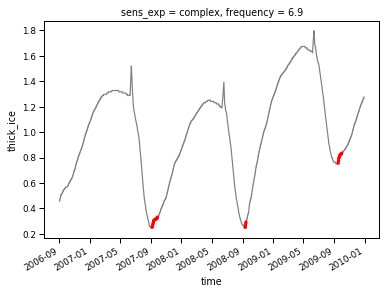

In [25]:
plt.figure()
memls_input_MYI['thick_ice'].plot(color='grey')
profiles_low_MYI['thick_ice'].plot(color='red',linewidth=3)

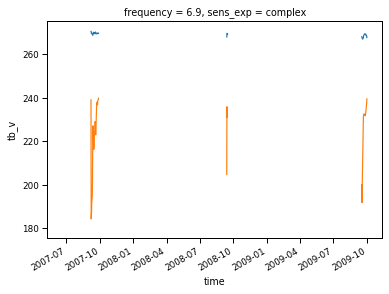

In [26]:
TBV_simp_low = memls_output_MYI_snowno['tb_v'].sel(sens_exp='simplesalfunc',frequency=6.9)
TBV_simp_low.where(np.isnan(low_MYI)==False,np.nan).plot()
low_MYI.where(np.isnan(low_MYI)==False,np.nan).plot()

Text(0.01, 18, '2007-11-02 TB = 266.49')

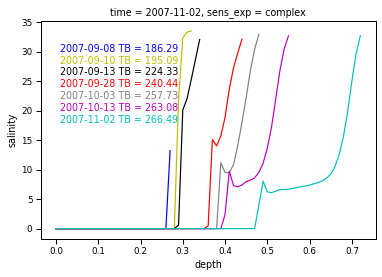

In [27]:
plt.figure()
profiles_low_MYI['salinity'].isel(time=740).plot(color='blue')
plt.text(0.01,30,str(TBV.time.isel(time=740).values)[0:10]+' TB = '+str(TBV.isel(time=740).values),color='blue')
profiles_low_MYI['salinity'].isel(time=745).plot(color='y')
plt.text(0.01,28,str(TBV.time.isel(time=745).values)[0:10]+' TB = '+str(TBV.isel(time=745).values),color='y')
memls_input_MYI['salinity'].sel(sens_exp='complex').isel(time=750).plot(color='k')
plt.text(0.01,26,str(TBV.time.isel(time=750).values)[0:10]+' TB = '+str(TBV.isel(time=750).values),color='k')
memls_input_MYI['salinity'].sel(sens_exp='complex').isel(time=780).plot(color='red')
plt.text(0.01,24,str(TBV.time.isel(time=780).values)[0:10]+' TB = '+str(TBV.isel(time=780).values),color='red')
memls_input_MYI['salinity'].sel(sens_exp='complex').isel(time=790).plot(color='grey')
plt.text(0.01,22,str(TBV.time.isel(time=790).values)[0:10]+' TB = '+str(TBV.isel(time=790).values),color='grey')
memls_input_MYI['salinity'].sel(sens_exp='complex').isel(time=810).plot(color='m')
plt.text(0.01,20,str(TBV.time.isel(time=810).values)[0:10]+' TB = '+str(TBV.isel(time=810).values),color='m')
memls_input_MYI['salinity'].sel(sens_exp='complex').isel(time=850).plot(color='c')
plt.text(0.01,18,str(TBV.time.isel(time=850).values)[0:10]+' TB = '+str(TBV.isel(time=850).values),color='c')


In [28]:
surf_lwf_ice_MYI.sel(sens_exp='complex').isel(time=range(2210+858,2270+858))

<xarray.DataArray (time: 60)>
array([1.2e-05, 9.0e-06, 8.0e-06, 8.0e-06, 7.0e-06, 8.0e-06, 8.0e-06,
       8.0e-06, 8.0e-06, 8.0e-06, 9.0e-06, 9.0e-06, 8.0e-06, 8.0e-06,
       8.0e-06, 8.0e-06, 9.0e-06, 8.0e-06, 1.1e-05, 1.4e-05, 1.6e-05,
       1.7e-05, 1.7e-05, 1.9e-05, 2.3e-05, 2.2e-05, 2.3e-05, 2.3e-05,
       2.1e-05, 2.0e-05, 1.9e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.6e-05,
       1.5e-05, 1.3e-05, 9.0e-06, 8.0e-06, 7.0e-06, 8.0e-06, 9.0e-06,
       1.0e-05, 1.2e-05, 1.4e-05, 1.2e-05, 1.3e-05, 1.4e-05, 1.7e-05,
       1.7e-05, 1.9e-05, 1.9e-05, 1.6e-05, 1.4e-05, 1.3e-05, 1.1e-05,
       1.1e-05, 1.0e-05, 1.0e-05, 1.0e-05])
Coordinates:
  * time      (time) datetime64[ns] 2009-09-12 ... 2009-10-11T12:00:00
    sens_exp  <U7 'complex'

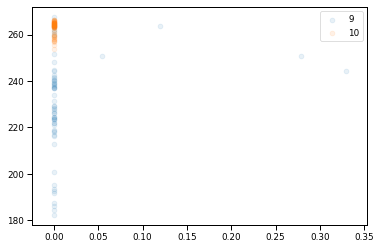

In [30]:
yy = 2007
bvf_yy = surf_lwf_ice_MYI.sel(sens_exp='complex').sel(time=TBV.time).sel(time=TBV['time.year']==yy)
TBV_yy = TBV.sel(time=TBV['time.year']==yy)
memls_input_MYI_yy = memls_input_MYI.sel(sens_exp='complex').sel(time=TBV['time.year']==yy)

plt.figure()
for mm in [9,10]:
    plt.scatter(bvf_yy.sel(time=TBV_yy['time.month']==mm),TBV_yy.sel(time=TBV_yy['time.month']==mm),label=str(mm),alpha=0.1)
plt.legend()    

In [34]:
profiles_low_MYI = memls_input_MYI.sel(sens_exp='complex')*mask_low_MYI
profiles_low_MYI_simp = memls_input_MYI.sel(sens_exp='simplesalfunc')*mask_low_MYI

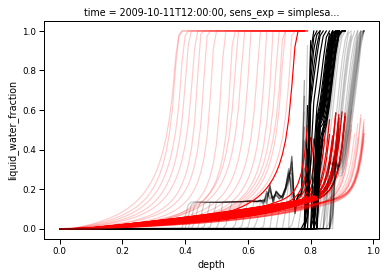

In [36]:
#example: range(1481,1490)
#example: range(750,780)
#example: range(2200,2310)

var='liquid_water_fraction'
plt.figure()
for tt in range(2200,2270):
    if np.isnan(low_MYI[tt]):
        memls_input_MYI[var].sel(sens_exp='complex').isel(time=tt).plot(color='k',alpha=0.2)
        memls_input_MYI[var].sel(sens_exp='simplesalfunc').isel(time=tt).plot(color='red',alpha=0.2)
    else:
        memls_input_MYI[var].sel(sens_exp='complex').isel(time=tt).plot(color='k')
        memls_input_MYI[var].sel(sens_exp='simplesalfunc').isel(time=tt).plot(color='red')

In [94]:
low_MYI.isel(time=range(2220,2270))

<xarray.DataArray 'tb_v' (time: 50)>
array([200.17, 191.87, 196.78, 202.96, 208.53, 214.16, 219.35, 223.74,
       227.97, 230.99, 232.26, 232.52, 232.41, 232.49, 232.65, 232.5 ,
       232.31, 232.03, 231.85, 231.85, 232.12, 232.53, 233.4 , 234.54,
       235.59, 236.34, 236.93, 237.7 , 239.57,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan])
Coordinates:
  * time       (time) datetime64[ns] 2009-09-17 ... 2009-10-11T12:00:00
    frequency  float64 6.9
    sens_exp   <U7 'complex'

Check out the relationship between snow thickness and TB

In [43]:
TBV_comp_FYI_snowyes = memls_output_FYI_snowyes['tb_v'].sel(sens_exp='complex',frequency=6.9)
TBV_comp_MYI_snowyes = memls_output_MYI_snowyes['tb_v'].sel(sens_exp='complex',frequency=6.9)
TBV_comp_FYI_snowno = memls_output_FYI_snowno['tb_v'].sel(sens_exp='complex',frequency=6.9)
TBV_comp_MYI_snowno = memls_output_MYI_snowno['tb_v'].sel(sens_exp='complex',frequency=6.9)

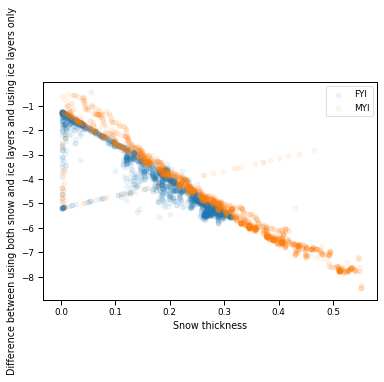

In [44]:
plt.figure()
plt.scatter(memls_input_FYI['thick_snow'],TBV_comp_FYI_snowyes-TBV_comp_FYI_snowno,label='FYI',alpha=alph)
plt.scatter(memls_input_MYI['thick_snow'],TBV_comp_MYI_snowyes-TBV_comp_MYI_snowno,label='MYI',alpha=alph)
plt.xlabel('Snow thickness')
plt.ylabel('Difference between using both snow and ice layers and using ice layers only')
plt.legend()

In [47]:
from scipy.stats import linregress

x0=memls_input_FYI['thick_snow'].values
y0=(TBV_comp_FYI_snowyes-TBV_comp_FYI_snowno).values

mask = [~np.isnan(x0) & ~np.isnan(y0)]

a_FYI = linregress(x0[mask],y0[mask]) #x and y are arrays or lists.



/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [48]:
a_FYI

LinregressResult(slope=-12.868407615066495, intercept=-1.6607102219712124, rvalue=-0.9135606343057935, pvalue=0.0, stderr=0.12730686324580595)

In [49]:
from scipy.stats import linregress

x0=memls_input_MYI['thick_snow'].values
y0=(TBV_comp_MYI_snowyes-TBV_comp_MYI_snowno).values

mask = [~np.isnan(x0) & ~np.isnan(y0)]

a_MYI = linregress(x0[mask],y0[mask]) #x and y are arrays or lists.

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [50]:
a_MYI

LinregressResult(slope=-12.422727124435815, intercept=-1.362806496415931, rvalue=-0.9583938351630488, pvalue=0.0, stderr=0.08331982291877932)